# **T-sne and viz on Kannada mnist dataset **

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
from IPython.display import Image
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.externals.six import StringIO
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz


import itertools
import seaborn as sns
import os
print(os.listdir('../input/Kannada-MNIST'))

['train.csv', 'Dig-MNIST.csv', 'test.csv', 'sample_submission.csv']


/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [ ]:
train_df = pd.read_csv('../input/Kannada-MNIST/train.csv')
test_df = pd.read_csv('../input/Kannada-MNIST/test.csv')
dig_df = pd.read_csv('../input/Kannada-MNIST/Dig-MNIST.csv')

In [ ]:
print(train_df.shape)
train_df.head()

(60000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df = test_df.drop(['id'], axis=1)

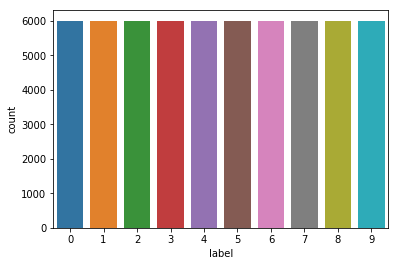

In [ ]:
sns.countplot(train_df['label'])
plt.show()

In [ ]:

x_train = (train_df.iloc[:,1:].values).astype('float32')
y_train = train_df.iloc[:,0].values.astype('int32')
x_test = test_df.values.astype('float32')


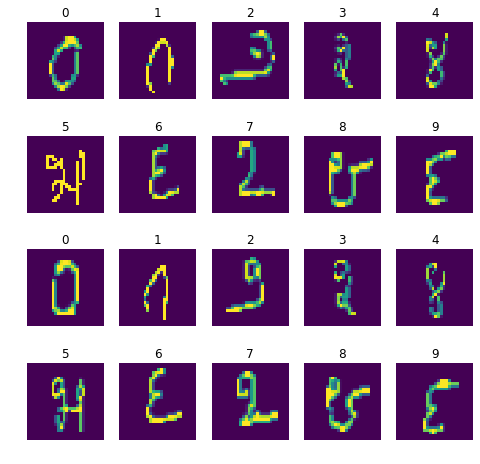

In [ ]:
plt.figure(figsize=(8,8))

x, y = 5, 4
for i in range(20):
    plt.subplot(y, x, i+1)
    plt.title(str(y_train[i]))
    plt.axis('off')
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest')
plt.show()

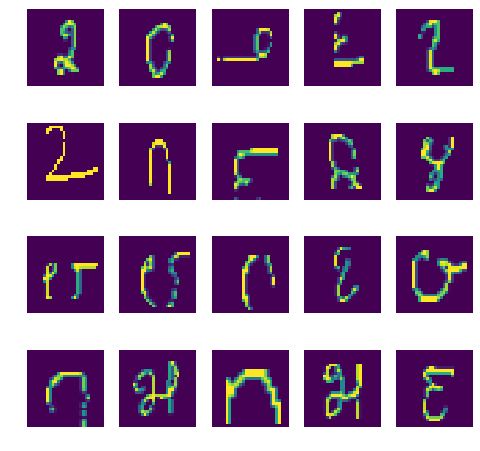

In [ ]:
plt.figure(figsize=(8,8))

x, y = 5, 4
for i in range(20):
    plt.subplot(y, x, i+1)
    #plt.title(str(y_train[i]))
    plt.axis('off')
    plt.imshow(x_test[i].reshape((28,28)),interpolation='nearest')
plt.show()

In [ ]:
concat_df = pd.concat([train_df, test_df])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [ ]:
features = [col for col in train_df.columns if col.startswith('pixel')]
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df['label'], test_size=0.25, random_state=42)

In [ ]:
def acc(y_true, y_pred):
    return round(accuracy_score(y_true, y_pred) * 100, 2)

clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

train_preds_baseline = clf.predict(X_train)
val_preds_baseline = clf.predict(X_val)
acc_baseline_train = acc(train_preds_baseline, y_train)
acc_baseline_val = acc(val_preds_baseline, y_val)

print(f'Training accuracy for our baseline (using all pixel features): {acc_baseline_train}%')
print(f'Validation accuracy for our baseline (using all pixel features): {acc_baseline_val}%')

Training accuracy for our baseline (using all pixel features): 86.23%
Validation accuracy for our baseline (using all pixel features): 84.16%


In [ ]:
tsvd = TruncatedSVD(n_components=50).fit_transform(concat_df[features])

In [ ]:
tsvd_cols = [f'component_{i+1}' for i in range(50)]
tsvd_train = pd.DataFrame(tsvd[:len(train_df)], columns=[tsvd_cols])
tsvd_test = pd.DataFrame(tsvd[len(train_df):], columns=[tsvd_cols])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(tsvd_train,
                                                  train_df['label'],
                                                  test_size=0.25,
                                                  random_state=42)

In [ ]:
# Train model with t-svd features
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [ ]:
train_preds = clf.predict(X_train)
val_preds = clf.predict(X_val)
acc_tsvd_train = acc(train_preds, y_train)
acc_tsvd_val = acc(val_preds, y_val)
print(f'Training accuracy with TSVD features (50 components): {acc_tsvd_train}%')
print(f'Validation accuracy with TSVD features (50 components): {acc_tsvd_val}%')
# Check out how it performed compared to the baseline
acc_diff = round(acc_tsvd_val - acc_baseline_val, 2)
print(f'\nThis is a difference of {acc_diff}% in validation accuracy compared to the baseline.')

Training accuracy with TSVD features (50 components): 92.57%
Validation accuracy with TSVD features (50 components): 89.26%

This is a difference of 5.1% in validation accuracy compared to the baseline.


## T_SNE

In [ ]:
%%time
tsne = TSNE()
transformed = tsne.fit_transform(tsvd)

CPU times: user 26min 32s, sys: 1.4 s, total: 26min 33s
Wall time: 26min 15s


In [ ]:
tsne_train = pd.DataFrame(transformed[:len(train_df)], columns=['component1', 'component2'])
tsne_test = pd.DataFrame(transformed[len(train_df):], columns=['component1', 'component2'])

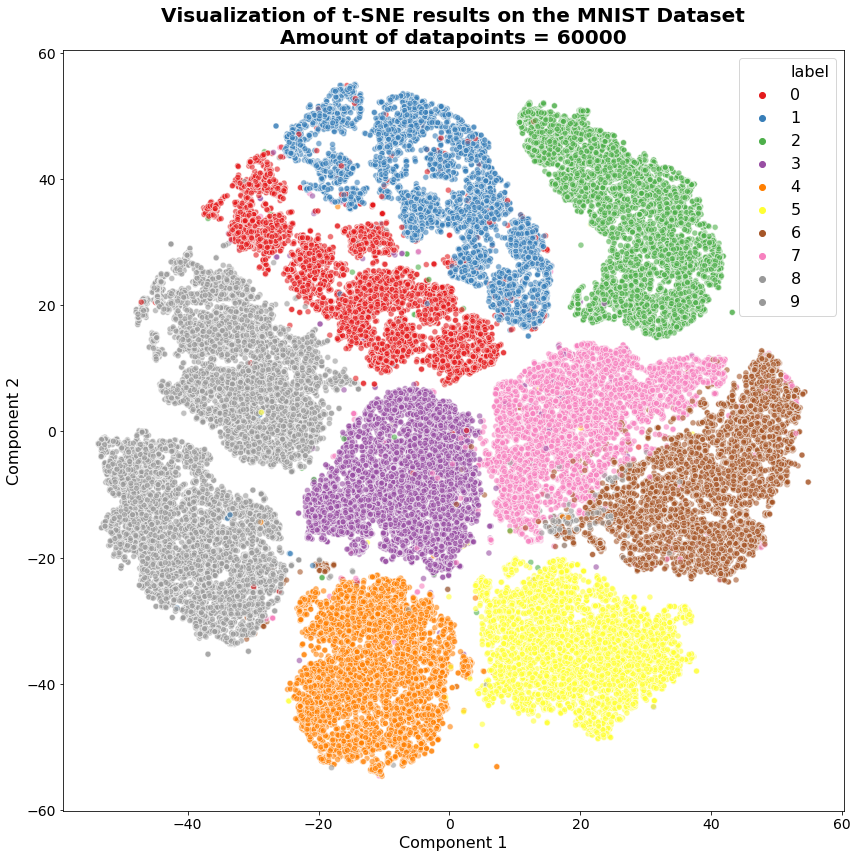

In [ ]:
plt.figure(figsize=(14, 14))
plt.title(f"Visualization of t-SNE results on the MNIST Dataset\n\
Amount of datapoints = {len(tsne_train)}", fontsize=20, weight='bold')
sns.scatterplot("component1", "component2",
                data=tsne_train, hue=train_df['label'],
                palette="Set1", legend="full", alpha=0.6)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16)
plt.show()